<h1> Answering Research Questions: <h1>

<h3>

## ML models ##

1. Can we predict whether an order will be completed or cancelled based on historical data?

2. Can we group our customer base into clusters? What does that reveal about our target audience?

3. Can we predict future sales by looking at historical data?


## EDA ##

4. Is there a correlation between payment method and order status?

5. What are the best-selling product categories, and how do sales trends vary over time?

6. Which product categories perform best, and how do their transaction profiles differ?
<h3>

## Imports ##

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)
import os
import warnings
import time
from IPython.display import display, HTML

<h1>1. Can we predict whether an order will be completed or cancelled based on historical data?</h1>

Confusion Matrix:
[[44439 22421]
 [19239 58733]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68     66860
           1       0.72      0.75      0.74     77972

    accuracy                           0.71    144832
   macro avg       0.71      0.71      0.71    144832
weighted avg       0.71      0.71      0.71    144832

AUC: 0.7693


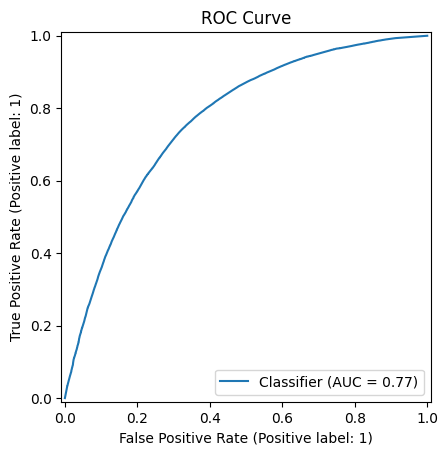


Top 20 Feature Importances:
grand_total                        0.269728
price                              0.242522
discount_amount                    0.172455
payment_method_cash_on_delivery    0.146329
payment_method_payment_gateway     0.041107
payment_method_easypay             0.029558
payment_method_credit              0.018097
qty_ordered                        0.013863
category_Others                    0.010231
payment_method_jazzcash            0.008681
category_Mobiles & Tablets         0.008280
category_Gifts                     0.006749
category_Superstore                0.006568
category_Men's Fashion             0.004839
category_Beauty & Grooming         0.003691
category_Women's Fashion           0.003527
category_Entertainment             0.003518
category_Computing                 0.002433
category_Home & Living             0.002300
category_Health & Sports           0.002190
dtype: float64


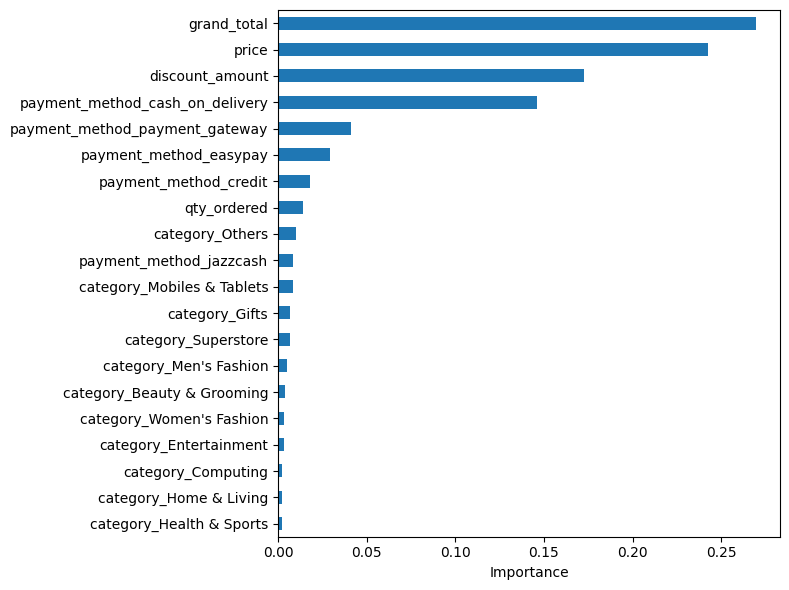


Directional Analysis for Top 4 Features:

*grand_total*
  Mean:  Canceled = 10,027.07 | Complete = 3,973.33
  Median:  Canceled = 1,499.00 | Complete = 699.00

*price*
  Mean:  Canceled = 9,239.00 | Complete = 3,956.78
  Median:  Canceled = 1,299.00 | Complete = 699.00

*discount_amount*
  Mean:  Canceled = 503.90 | Complete = 426.07
  Median:  Canceled = 0.00 | Complete = 0.00

*payment_method_cash_on_delivery*
  Cash on Delivery - Cancellation Rate: 27.97%, Completion Rate: 72.03%


In [2]:
# 1. Load and filter
df = pd.read_csv('preprocessed_dataset.csv',
                 parse_dates=['created_at'], low_memory=False)
df = df[df['status'].isin(['complete', 'canceled'])].copy()
df['is_complete'] = (df['status'] == 'complete').astype(int)

# 2. Select features & encode
features = ['category', 'payment_method', 'price', 'qty_ordered', 'discount_amount', 'grand_total']
X = pd.get_dummies(df[features], drop_first=True)
y = df['is_complete']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4. Train model
model = RandomForestClassifier(
    n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')
plt.show()

# 6. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
top = importances.sort_values(ascending=False).head(20)

print("\nTop 20 Feature Importances:")
print(top)

plt.figure(figsize=(8, 6))
top.plot.barh()
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- after printing Top 20 feature importances ---

# 7. Directional Analysis for Top 4 Features
top4 = top.index[:4].tolist()
print("\nDirectional Analysis for Top 4 Features:")
for feature in top4:
    print(f"\n*{feature}*")
    if feature in ['grand_total', 'price', 'discount_amount']:
        stats = df.groupby('status')[feature].agg(['mean', 'median'])
        # formatted print
        for stat in ['mean', 'median']:
            vals = stats[stat].apply(lambda x: f"{x:,.2f}")
            print(f"  {stat.title()}:  Canceled = {vals['canceled']} | Complete = {vals['complete']}")
    elif feature == 'payment_method_cash_on_delivery':
        # compute cancellation/completion rates for COD
        rates = df[df['payment_method'] == 'cash_on_delivery']['status'].value_counts(normalize=True)
        can = rates.get('canceled', 0)
        comp = rates.get('complete', 0)
        print(f"  Cash on Delivery - Cancellation Rate: {can:.2%}, Completion Rate: {comp:.2%}")
    else:
        print("  (No directional analysis implemented for this feature.)")

## 2. Can we group our customer base into clusters? What does that reveal about our target audience? ###

Loading dataset from: preprocessed_dataset.csv
Dataset loaded successfully. Original shape: (579327, 21)
Dropped 11 rows with missing 'customer_id'.
Found 114814 unique customers.

Aggregating purchasing data per customer...
Customer aggregated data shape: (114814, 8)

Scaling features using StandardScaler...
Scaled features shape: (114814, 7)

Calculating WCSS for Elbow Method...
Elbow method calculation time: 5.08 seconds


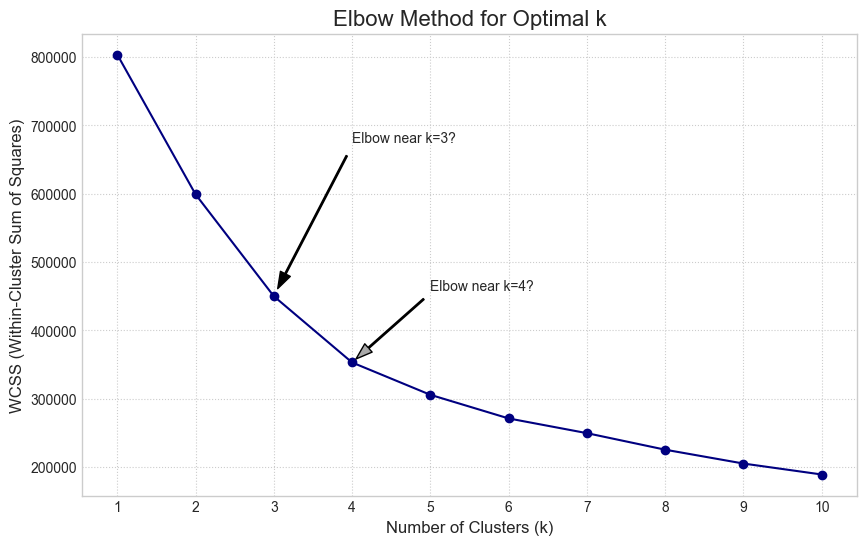

Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').

Calculating Silhouette Scores...
Using sample of 15000 for Silhouette (total: 114814)
  k=2, Silhouette Score: N/A (only 1 cluster assigned).
  k=3, Silhouette Score: 0.9782
  k=4, Silhouette Score: 0.7997
  k=5, Silhouette Score: 0.7831
  k=6, Silhouette Score: 0.7736
  k=7, Silhouette Score: 0.7790
  k=8, Silhouette Score: 0.7034
  k=9, Silhouette Score: 0.7036
  k=10, Silhouette Score: 0.7055
Silhouette score calculation time: 25.99 seconds


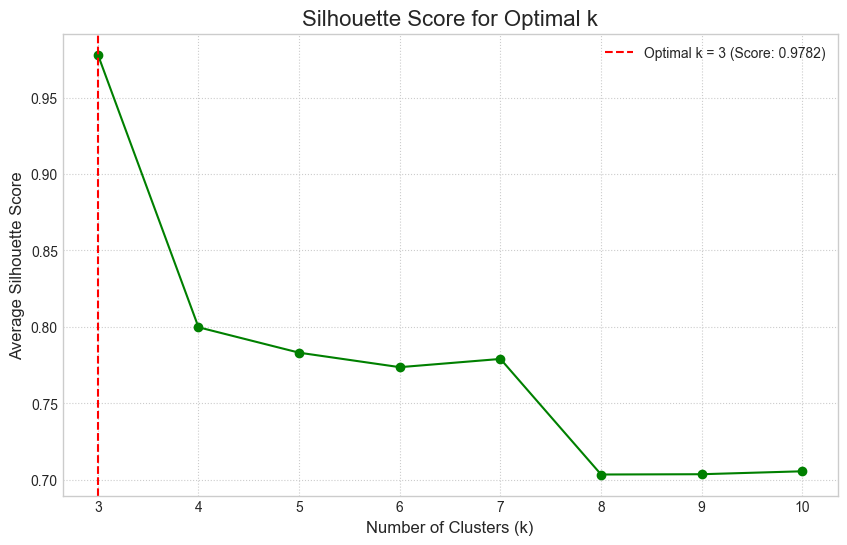


Optimal k suggested by Silhouette Score: 3

Selected k = 3 based on Silhouette score.

Running K-Means clustering with k=3...
K-Means fitting completed in 0.30 seconds.

Cluster labels assigned.

Cluster distribution:
cluster
0    114740
1         1
2        73
Name: count, dtype: int64

--- Analyzing Cluster Characteristics ---

Cluster Profile (Mean Values & Size):


,total_spending,frequency,average_order_value,total_quantity,average_quantity_per_order,total_discount,average_discount_per_order,cluster_size
cluster,,,,,,,,
0,"30,714.73",3.22,"7,607.23",5.92,1.73,"2,244.93",501.76,"114,740.00"
1,"17,888,000.00",1.00,"17,888,000.00","2,000.00","2,000.00",0.00,0.00,1.00
2,"5,187,772.72",510.25,"32,572.23",936.36,4.07,"137,861.64",404.13,73.00
Overall Mean,"34,149.18",3.54,"7,778.83",6.53,1.75,"2,331.14",501.69,"114,814.00"



--- Visualizing Clusters ---
Note: Log scale for Spending skipped due to non-positive values in sample.


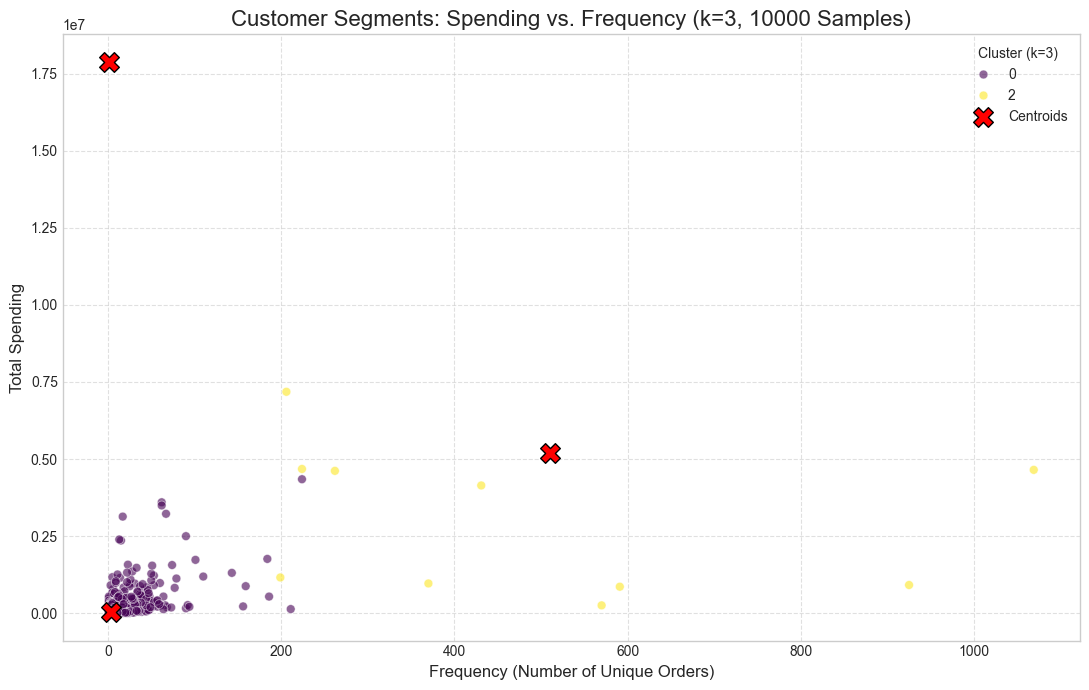


--- Visualizing Feature Distributions by Cluster ---


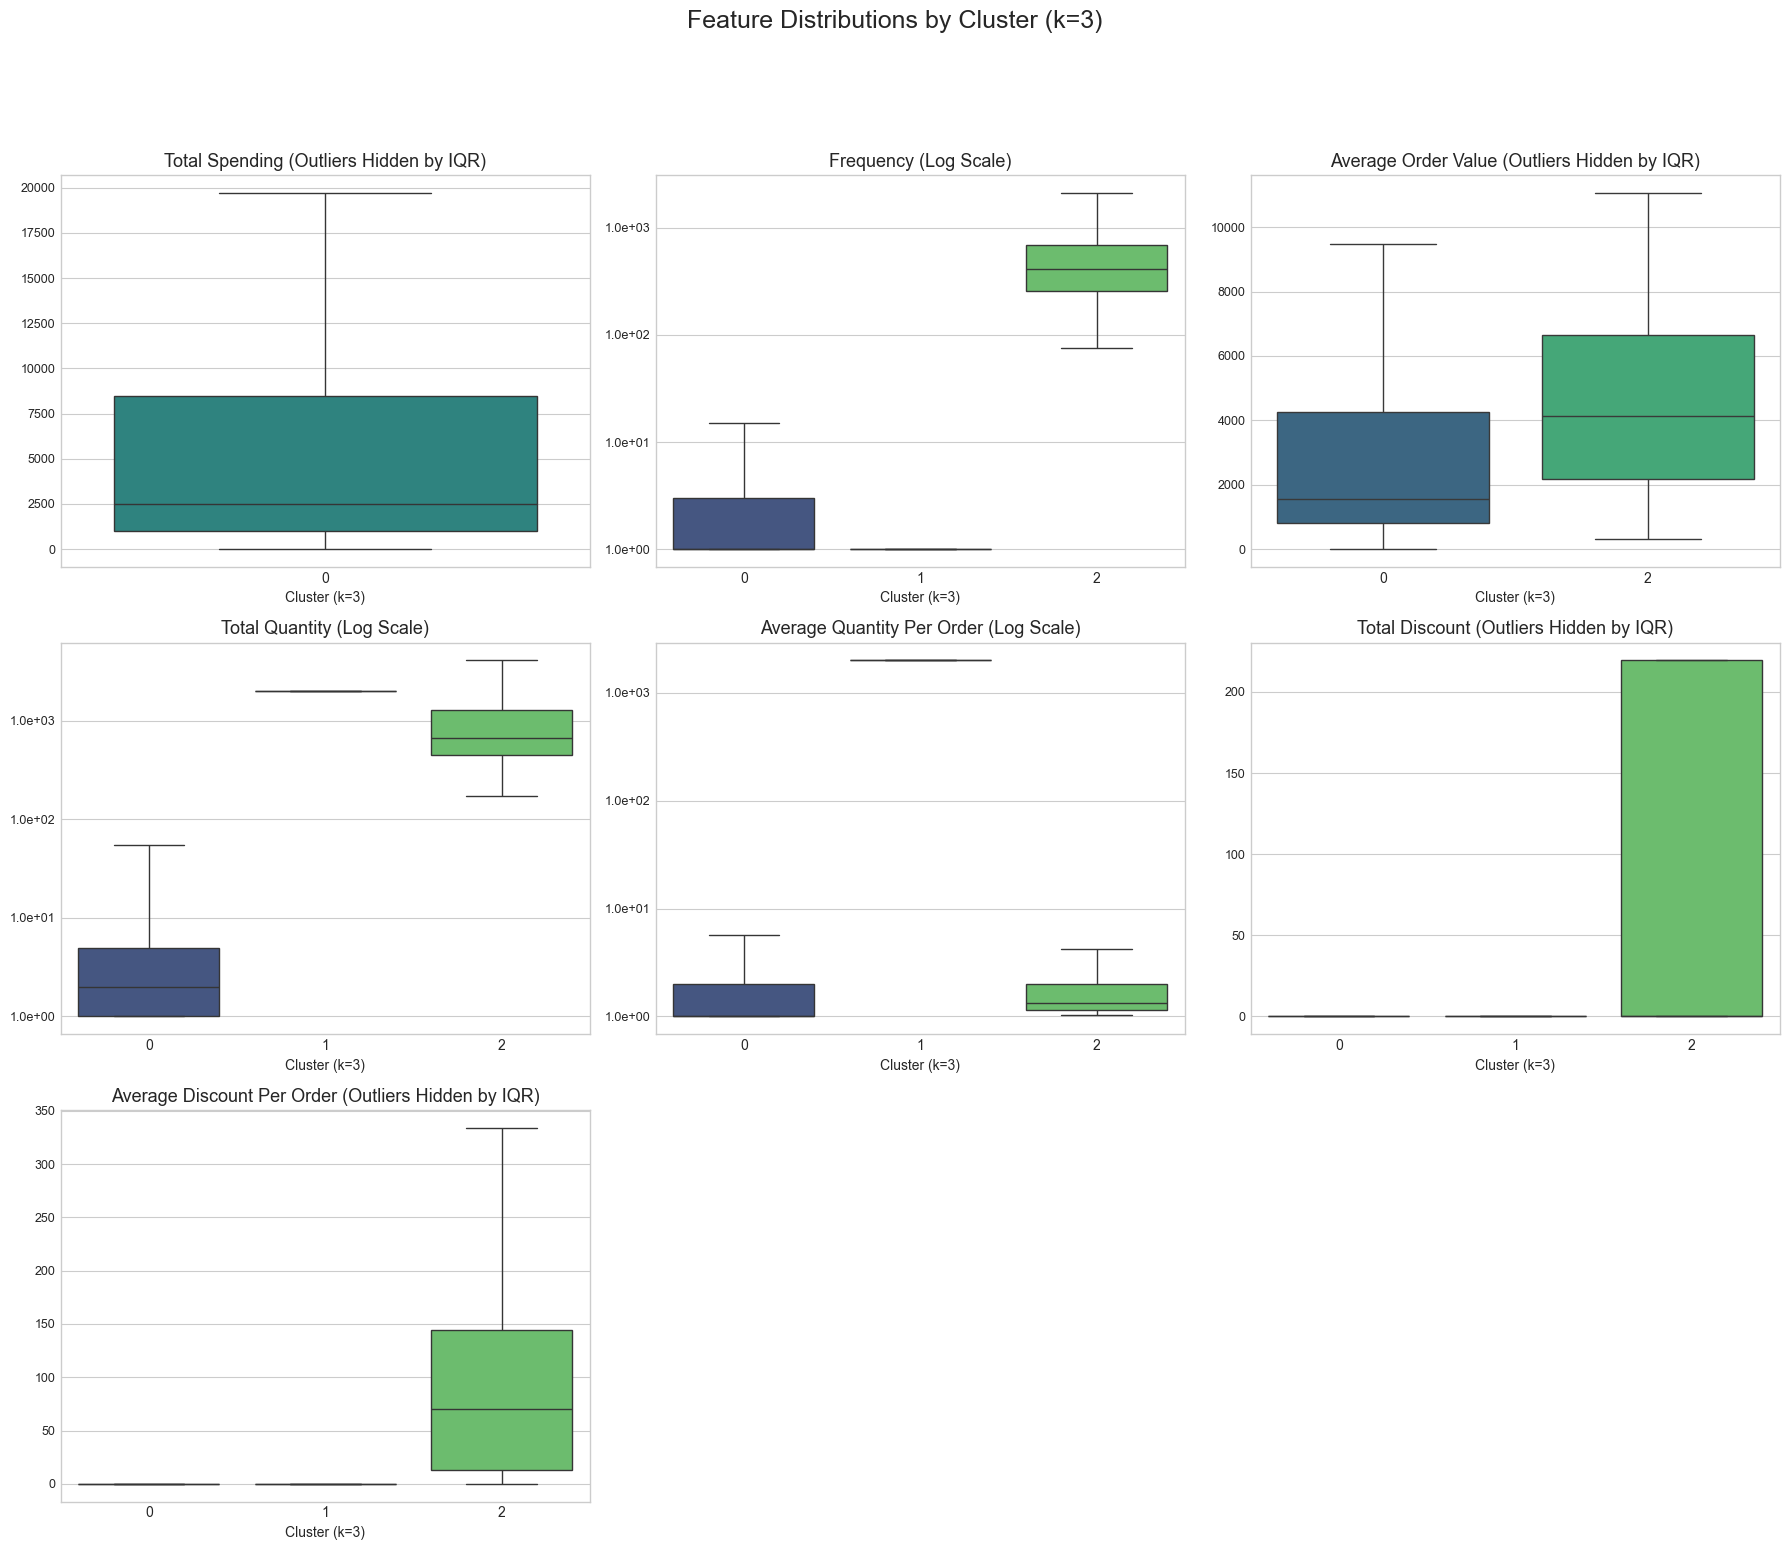


--- Cluster Interpretation Summary (k=3) ---

Cluster 0 (Size: 114740, 99.9% of total)
  Key Traits: Average Spending, Average Frequency, Average AOV
  Suggested Profile: Core Customers

Cluster 1 (Size: 1, 0.0% of total)
  Key Traits: Very High Spending, Very Infrequent, High AOV
  Suggested Profile: Big Spenders (Occasional)

Cluster 2 (Size: 73, 0.1% of total)
  Key Traits: Very High Spending, Very Frequent, High AOV
  Suggested Profile: VIP Loyalists

Note: Thresholds and segment names are heuristic suggestions based on averages.

--- Customer Segmentation Analysis Complete ---


In [3]:
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


DATASET_PATH = 'preprocessed_dataset.csv'
CUSTOMER_ID_COL = 'customer_id'
ORDER_ID_COL = 'increment_id'

AGGREGATION_METRICS = {
    'total_spending': ('grand_total', 'sum'),
    'frequency': (ORDER_ID_COL, 'nunique'),
    'total_quantity': ('qty_ordered', 'sum'),
    'total_discount': ('discount_amount', 'sum'),
}

FEATURES_FOR_CLUSTERING_BASE = [
    'total_spending',
    'frequency',
    'average_order_value',
    'total_quantity',
    'average_quantity_per_order',
    'total_discount',
    'average_discount_per_order'
]

MAX_K_TO_TEST = 10
SILHOUETTE_SAMPLE_SIZE = 15000
DEFAULT_K = 3



if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    exit()
else:
    print(f"Loading dataset from: {DATASET_PATH}")
    try:
        df = pd.read_csv(DATASET_PATH)
        print(f"Dataset loaded successfully. Original shape: {df.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        exit()


if CUSTOMER_ID_COL not in df.columns:
    print(f"Error: Customer ID column '{CUSTOMER_ID_COL}' not found.")
    exit()

original_rows = df.shape[0]
df.dropna(subset=[CUSTOMER_ID_COL], inplace=True)
rows_dropped = original_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows with missing '{CUSTOMER_ID_COL}'.")

unique_customers = df[CUSTOMER_ID_COL].nunique()
print(f"Found {unique_customers} unique customers.")



print("\nAggregating purchasing data per customer...")
required_agg_cols = [CUSTOMER_ID_COL, ORDER_ID_COL] + [val[0] for val in AGGREGATION_METRICS.values()]
missing_req_cols = [col for col in required_agg_cols if col not in df.columns]
if missing_req_cols:
    print(f"Error: Missing required columns for aggregation: {list(set(missing_req_cols))}")
    exit()


customer_agg = df.groupby(CUSTOMER_ID_COL).agg(**AGGREGATION_METRICS).reset_index()


if 'frequency' in customer_agg.columns and 'total_spending' in customer_agg.columns:
    customer_agg['average_order_value'] = customer_agg.apply(
        lambda row: row['total_spending'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_quantity' in customer_agg.columns:
    customer_agg['average_quantity_per_order'] = customer_agg.apply(
        lambda row: row['total_quantity'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_discount' in customer_agg.columns:
    customer_agg['average_discount_per_order'] = customer_agg.apply(
        lambda row: row['total_discount'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)

print(f"Customer aggregated data shape: {customer_agg.shape}")


actual_features = [f for f in FEATURES_FOR_CLUSTERING_BASE if f in customer_agg.columns]
if not actual_features:
    print("Error: No clustering features exist in the aggregated data.")
    exit()
elif len(actual_features) < len(FEATURES_FOR_CLUSTERING_BASE):
    print(f"Warning: Using subset of features: {actual_features}")

X_clustering = customer_agg[actual_features].copy()


if X_clustering.isnull().sum().sum() > 0:
    print("Warning: Filling NaN values with 0 before scaling.")
    X_clustering = X_clustering.fillna(0)

infinite_mask = np.isinf(X_clustering).any()
if infinite_mask.any():
    print("Warning: Replacing infinite values with 0 before scaling.")
    X_clustering = X_clustering.replace([np.inf, -np.inf], 0)


print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
print(f"Scaled features shape: {X_scaled.shape}")



print("\nCalculating WCSS for Elbow Method...")
wcss = []
possible_k_elbow = range(1, MAX_K_TO_TEST + 1)
start_elbow = time.time()

for k_val in possible_k_elbow:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    wcss.append(kmeans_test.inertia_)

end_elbow = time.time()
print(f"Elbow method calculation time: {end_elbow - start_elbow:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(possible_k_elbow, wcss, marker='o', linestyle='-', color='navy')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(possible_k_elbow)
if len(wcss) > 2:
    plt.annotate('Elbow near k=3?', xy=(3, wcss[2]), xytext=(4, wcss[2]*1.5),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)
if len(wcss) > 3:
    plt.annotate('Elbow near k=4?', xy=(4, wcss[3]), xytext=(5, wcss[3]*1.3),
                 arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)

plt.grid(True, linestyle=':')
plt.show()
print("Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').")


print("\nCalculating Silhouette Scores...")
silhouette_scores = []
possible_k_sil = range(2, MAX_K_TO_TEST + 1)
start_sil = time.time()
optimal_k_silhouette = -1


X_silhouette = X_scaled
indices_silhouette = None
if SILHOUETTE_SAMPLE_SIZE is not None and X_scaled.shape[0] > SILHOUETTE_SAMPLE_SIZE:
    print(f"Using sample of {SILHOUETTE_SAMPLE_SIZE} for Silhouette (total: {X_scaled.shape[0]})")
    indices_silhouette = np.random.choice(X_scaled.shape[0], SILHOUETTE_SAMPLE_SIZE, replace=False)
    X_silhouette = X_scaled[indices_silhouette]
else:
     print(f"Using full dataset ({X_scaled.shape[0]} points) for Silhouette.")

for k_val in possible_k_sil:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    cluster_labels_full = kmeans_test.fit_predict(X_scaled)

    if indices_silhouette is not None:
        labels_for_silhouette = cluster_labels_full[indices_silhouette]
    else:
        labels_for_silhouette = cluster_labels_full

    score = -1
    if len(np.unique(labels_for_silhouette)) > 1:
         try:
            score = silhouette_score(X_silhouette, labels_for_silhouette)
            print(f"  k={k_val}, Silhouette Score: {score:.4f}")
         except Exception as e:
            print(f"  k={k_val}, Silhouette Calc Error: {e}")
            score = -99
    else:
         print(f"  k={k_val}, Silhouette Score: N/A (only 1 cluster assigned).")

    silhouette_scores.append(score)

end_sil = time.time()
print(f"Silhouette score calculation time: {end_sil - start_sil:.2f} seconds")


valid_indices = [i for i, s in enumerate(silhouette_scores) if s > -1]
if valid_indices:
    valid_k = [possible_k_sil[i] for i in valid_indices]
    valid_scores = [silhouette_scores[i] for i in valid_indices]

    if valid_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(valid_k, valid_scores, marker='o', linestyle='-', color='green')
        plt.title('Silhouette Score for Optimal k', fontsize=16)
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Average Silhouette Score', fontsize=12)
        plt.xticks(valid_k)

        max_score_index = np.argmax(valid_scores)
        optimal_k_silhouette = valid_k[max_score_index]
        plt.axvline(optimal_k_silhouette, color='red', linestyle='--',
                    label=f'Optimal k = {optimal_k_silhouette} (Score: {valid_scores[max_score_index]:.4f})')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.show()
        print(f"\nOptimal k suggested by Silhouette Score: {optimal_k_silhouette}")
    else:
         print("\nNo valid Silhouette scores available to plot.")
else:
    print("\nCould not plot Silhouette Scores (no valid scores calculated).")


if optimal_k_silhouette != -1 and optimal_k_silhouette >= 2:
    chosen_k = optimal_k_silhouette
    print(f"\nSelected k = {chosen_k} based on Silhouette score.")
else:
    chosen_k = DEFAULT_K
    print(f"\nUsing default k = {chosen_k}. Review Elbow plot manually.")



if chosen_k < 2:
    print(f"Error: Invalid number of clusters selected (k={chosen_k}). Must be >= 2.")
    exit()

print(f"\nRunning K-Means clustering with k={chosen_k}...")
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10)

if X_scaled.shape[0] == 0:
     print("Error: Scaled data is empty.")
     exit()

try:
    start_kmeans = time.time()
    cluster_labels = kmeans.fit_predict(X_scaled)
    end_kmeans = time.time()
    print(f"K-Means fitting completed in {end_kmeans - start_kmeans:.2f} seconds.")

    customer_agg['cluster'] = cluster_labels
    print("\nCluster labels assigned.")
    print("\nCluster distribution:")
    cluster_counts = customer_agg['cluster'].value_counts().sort_index()
    print(cluster_counts)

except Exception as e:
     print(f"An error occurred during K-Means fitting: {e}")
     exit()



if 'cluster' not in customer_agg.columns:
    print("Error: Cluster labels not found. Skipping analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    cluster_analysis = customer_agg.groupby('cluster')[actual_features].mean()
    cluster_analysis['cluster_size'] = cluster_counts
    overall_mean = customer_agg[actual_features].mean()
    overall_mean['cluster_size'] = customer_agg.shape[0]
    cluster_analysis.loc['Overall Mean'] = overall_mean

    print("\nCluster Profile (Mean Values & Size):")
    display(cluster_analysis.style.format("{:,.2f}"))

    print("\n--- Visualizing Clusters ---")


    plt.figure(figsize=(11, 7))
    plot_sample_size = min(len(customer_agg), 10000)
    scatter_data = customer_agg.sample(plot_sample_size, random_state=42)

    sns.scatterplot(data=scatter_data, x='frequency', y='total_spending', hue='cluster',
                    palette='viridis', s=40, alpha=0.6, legend='full')

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=actual_features)
    if 'frequency' in centroids_df.columns and 'total_spending' in centroids_df.columns:
        plt.scatter(centroids_df['frequency'], centroids_df['total_spending'], marker='X', s=200,
                    c='red', edgecolor='black', label='Centroids', zorder=5)

    plt.title(f'Customer Segments: Spending vs. Frequency (k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    plt.xlabel('Frequency (Number of Unique Orders)', fontsize=12)
    plt.ylabel('Total Spending', fontsize=12)


    can_log_scale_x = (scatter_data['frequency'] > 0).all()
    can_log_scale_y = (scatter_data['total_spending'] > 0).all()
    if can_log_scale_x and can_log_scale_y:
         plt.xscale('log')
         plt.yscale('log')
         plt.xlabel('Frequency (Log Scale)', fontsize=12)
         plt.ylabel('Total Spending (Log Scale)', fontsize=12)
         plt.title(f'Customer Segments: Spending vs. Frequency (Log Scale, k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    elif not can_log_scale_x:
         print("Note: Log scale for Frequency skipped due to non-positive values in sample.")
    elif not can_log_scale_y:
         print("Note: Log scale for Spending skipped due to non-positive values in sample.")

    plt.legend(title=f'Cluster (k={chosen_k})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    print("\n--- Visualizing Feature Distributions by Cluster ---")
    num_features_plot = len(actual_features)
    ncols_plot = min(3, num_features_plot)
    nrows_plot = int(np.ceil(num_features_plot / ncols_plot))
    fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot, figsize=(ncols_plot * 6, nrows_plot * 5), squeeze=False)
    axes = axes.flatten()

    for i, feature in enumerate(actual_features):
        ax = axes[i]
        plot_data = customer_agg[['cluster', feature]].copy()
        log_scale_applied = False
        title_suffix = ""

        if (plot_data[feature] > 0).all():
            try:
                ax.set_yscale('log')
                log_scale_applied = True
                title_suffix = " (Log Scale)"
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
            except Exception as e:
                 print(f"Could not apply log scale to {feature}: {e}")
                 log_scale_applied = False

        if not log_scale_applied:
            Q1 = plot_data[feature].quantile(0.25)
            Q3 = plot_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            plot_data_filtered = plot_data[(plot_data[feature] >= lower_bound) & (plot_data[feature] <= upper_bound)]

            if len(plot_data_filtered) / len(plot_data) > 0.1:
                 plot_data_to_show = plot_data_filtered
                 title_suffix = " (Outliers Hidden by IQR)"
            else:
                 plot_data_to_show = plot_data
                 title_suffix = " (Outliers Present)"
            ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
        else:
             plot_data_to_show = plot_data

        sns.boxplot(data=plot_data_to_show, x='cluster', y=feature, ax=ax, palette='viridis', showfliers=False)

        ax.set_title(f'{feature.replace("_", " ").title()}{title_suffix}', fontsize=13)
        ax.set_xlabel(f'Cluster (k={chosen_k})', fontsize=10)
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=9)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Feature Distributions by Cluster (k={chosen_k})', fontsize=18, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


    print(f"\n--- Cluster Interpretation Summary (k={chosen_k}) ---")
    analysis_sorted = cluster_analysis.drop('Overall Mean').sort_index()
    overall_means = cluster_analysis.loc['Overall Mean']

    thresholds = {'Very High': 1.75, 'High': 1.15, 'Low': 0.85, 'Very Low': 0.5}

    for cluster_id in analysis_sorted.index:
        cluster_data = analysis_sorted.loc[cluster_id]
        size = cluster_data['cluster_size']
        percentage = size / overall_means['cluster_size'] * 100
        print(f"\nCluster {cluster_id} (Size: {int(size)}, {percentage:.1f}% of total)")

        desc = []
        relative_spend = cluster_data['total_spending'] / overall_means['total_spending'] if overall_means['total_spending'] else 1
        relative_freq = cluster_data['frequency'] / overall_means['frequency'] if overall_means['frequency'] else 1
        relative_aov = cluster_data['average_order_value'] / overall_means['average_order_value'] if overall_means['average_order_value'] else 1


        if relative_spend >= thresholds['Very High']: desc.append("Very High Spending")
        elif relative_spend >= thresholds['High']: desc.append("High Spending")
        elif relative_spend <= thresholds['Very Low']: desc.append("Very Low Spending")
        elif relative_spend <= thresholds['Low']: desc.append("Low Spending")
        else: desc.append("Average Spending")

        if relative_freq >= thresholds['Very High']: desc.append("Very Frequent")
        elif relative_freq >= thresholds['High']: desc.append("Frequent")
        elif relative_freq <= thresholds['Very Low']: desc.append("Very Infrequent")
        elif relative_freq <= thresholds['Low']: desc.append("Infrequent")
        else: desc.append("Average Frequency")

        if relative_aov >= thresholds['High']: desc.append("High AOV")
        elif relative_aov <= thresholds['Low']: desc.append("Low AOV")
        else: desc.append("Average AOV")

        print(f"  Key Traits: {', '.join(desc)}")


        segment_name = f"General Segment {cluster_id}"
        if "Very High Spending" in desc and "Very Frequent" in desc: segment_name = "VIP Loyalists"
        elif ("High Spending" in desc or "Very High Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "High Value Regulars"
        elif ("Low Spending" in desc or "Very Low Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Low Engagement / At Risk"
        elif ("High Spending" in desc or "Very High Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Big Spenders (Occasional)"
        elif ("Average Spending" in desc or "Low Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "Frequent Browsers / Small Buys"
        elif "Average Spending" in desc and "Average Frequency" in desc and "Average AOV" in desc: segment_name = "Core Customers"


        print(f"  Suggested Profile: {segment_name}")
    print("\nNote: Thresholds and segment names are heuristic suggestions based on averages.")

print("\n--- Customer Segmentation Analysis Complete ---")

## 3. Can we predict future sales by looking at historical data? ##

In [ ]:
warnings.filterwarnings('ignore') 
%matplotlib inline

# Data Ingestion
DATASET_FILEPATH = 'preprocessed_dataset.csv'

df = pd.read_csv(DATASET_FILEPATH, low_memory=False)

# Data Transformation & Visualization
sales_data = df[['created_at', 'grand_total']].dropna()
sales_data['created_at'] = pd.to_datetime(sales_data['created_at'], errors='coerce')
sales_data['grand_total'] = pd.to_numeric(sales_data['grand_total'], errors='coerce')
sales_data.dropna(subset=['created_at', 'grand_total'], inplace=True)
sales_data.set_index('created_at', inplace=True)
monthly_summary = sales_data.resample('M').sum().reset_index()
monthly_summary['grand_total'] = monthly_summary['grand_total'].apply(lambda x: max(x, 1e-5))

# Time Series Extension
last_historical_date = monthly_summary['created_at'].max()
forecast_start_date = max(last_historical_date + pd.offsets.MonthEnd(1), pd.to_datetime('2018-09-30'))
forecast_end_date = pd.to_datetime('2019-08-31')
future_periods = pd.date_range(forecast_start_date, forecast_end_date, freq='M')
full_date_range = pd.Index(monthly_summary['created_at']).union(future_periods)
monthly_summary_full = pd.merge(monthly_summary, pd.DataFrame({'created_at': full_date_range}), on='created_at', how='right')

# Feature Creation
monthly_summary_full['time_index'] = range(1, len(monthly_summary_full) + 1)
monthly_summary_full['log_sales_target'] = np.log10(monthly_summary_full['grand_total'])
for month in range(1, 13):
    monthly_summary_full[f'month_is_{month}'] = (monthly_summary_full['created_at'].dt.month == month).astype(int)

# Data Splitting
n_train_months = 20
feature_cols = ['time_index'] + [f'month_is_{m}' for m in range(2, 13)]
train_data = monthly_summary_full.iloc[:n_train_months]
test_data = monthly_summary_full.iloc[n_train_months:]

# Train the model
X_train, y_train = train_data[feature_cols], train_data['log_sales_target']
X_test, y_test = test_data[feature_cols], test_data['log_sales_target']
model = LinearRegression().fit(X_train, y_train)

# Predict and Evaluate
def evaluate(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

train_metrics = evaluate(y_train, model.predict(X_train))
test_metrics = evaluate(y_test, model.predict(X_test))

print(f"Train Metrics: {train_metrics}")
print(f"Test Metrics: {test_metrics}")

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train_data['created_at'], 10**y_train, label='Train Actual', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.plot(test_data['created_at'], 10**y_test, label='Test Actual', marker='o', linestyle='-', color='green', alpha=0.8)
plt.plot(test_data['created_at'], 10**model.predict(X_test), label='Test Forecast', marker='x', linestyle='--', color='orange')
plt.title('Sales Forecasting with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Analysis Complete")


ValueError: Invalid file path or buffer object type: <class 'NoneType'>